<a href="https://colab.research.google.com/github/da-on-git/recognize_speech_command/blob/main/OptimizeModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Optimize and Evaluate a Minimal Viable Model (MVM)

Load audio files into runtime disk space

In [ ]:
%%time
%pip install wget
import wget
url = 'https://lp-prod-resources.s3.us-west-2.amazonaws.com/234/google_speech_new.zip'
fname = wget.download(url)
!unzip -q $fname -d /content/
import os
os.remove(fname) #Remove downloaded zip file
import shutil
shutil.rmtree('/content/__MACOSX') #Remov Mac specific files
# For compatibility with the csv file name
os.rename('/content/google_speech/validation', '/content/google_speech/validate')

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=6a052d89720fcb738a29377d82dc9ac001285be3d433e68e9da59471e32bc33e
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
CPU times: user 4.43 s, sys: 4.43 s, total: 8.86 s
Wall time: 2min 15s


Set path variables for building the mel-spectrogram data files

In [ ]:
from pathlib import Path
current_dir = Path('.')
data_path = current_dir / 'google_speech'
spectograms_path = current_dir / 'spectograms'


Remove all spectogram files

In [ ]:
import shutil
shutil.rmtree (spectograms_path, ignore_errors=True)

A function to pad audio clips with zero to have a uniform length

In [ ]:
import numpy as np
def pad_audio_with_silence(audio: np.ndarray, target_n_samples: int):
    assert audio.shape[0] <= target_n_samples, f"Audio is larger than {target_n_samples}"
    padded_audio = np.zeros(target_n_samples)
    padded_audio[:audio.shape[0]] = audio
    return padded_audio

A function to create one mel-spectogram file

In [ ]:
n_samples = 16000
n_fft = 2048
hop_length = n_fft // 4
n_mels = 128

import librosa as lb
import numpy as np
import os
from tensorflow import keras
from keras import utils

def save_mel(file_path):
    wav_path = Path(file_path)
    mel_path = wav_path.with_suffix('.png')
    if os.path.isfile(audio_path / wav_path):
        y, sr = lb.load(audio_path / wav_path, sr=None)
        y = pad_audio_with_silence(y,n_samples)
        S = lb.feature.melspectrogram(y=y, sr=sr,  n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        S_dB = lb.power_to_db(S, ref=np.max)
        assert S_dB.shape[1] == 32, f"mel size is not 32"
        utils.save_img(spec_path / mel_path, np.expand_dims(S_dB, axis=2),
              data_format=None, file_format=None, scale=True)
        return S_dB.shape
    else:
        print("File not found: ", wav_path)
        return (0,0)


Select a split to generate,
Read the split csv file and extract labels,
Make directories for the split,
Generate spectograms for a split

In [ ]:
%%time

import pandas as pd
import os

splits = ['train', 'test', 'validate']
scale_down_factor = 1

for split in splits:
    audio_path = data_path / split / 'audio'
    spec_path = spectograms_path / split
    split_csv_path = data_path / split / f"{split}.csv"

    split_csv_df= pd.read_csv(split_csv_path)
    labels = split_csv_df['label'].unique()
    split_len = split_csv_df.shape[0]
    apply_len = split_len // scale_down_factor

    print(f"{split}: {apply_len} out of {split_len}")

    for category in (labels):
      os.makedirs(spec_path / category)

    apply_df = split_csv_df.sample(n=apply_len).copy()
    result = apply_df['file_path'].apply(save_mel)

train: 51088 out of 51088
test: 6835 out of 6835
validate: 6798 out of 6798
File not found:  no/86402da1_nohash_0.wav
File not found:  no/b487da60_nohash_0.wav
File not found:  no/d57febf0_nohash_1.wav
File not found:  no/c50225fa_nohash_3.wav
File not found:  no/c5e3817f_nohash_0.wav
File not found:  no/ae927455_nohash_0.wav
File not found:  no/52e228e9_nohash_2.wav
File not found:  no/bdee441c_nohash_6.wav
File not found:  no/c50225fa_nohash_2.wav
File not found:  no/794cdfc5_nohash_0.wav
File not found:  no/989a2213_nohash_2.wav
File not found:  no/ccea893d_nohash_0.wav
File not found:  no/e8c3c5ca_nohash_2.wav
File not found:  no/dd086776_nohash_1.wav
File not found:  no/e8e960fd_nohash_1.wav
File not found:  no/8910e5ef_nohash_2.wav
File not found:  no/a8cf01bc_nohash_1.wav
File not found:  no/c24d96eb_nohash_2.wav
File not found:  no/605ed0ff_nohash_0.wav
File not found:  no/f9ebdba0_nohash_0.wav
File not found:  no/b0f24c9b_nohash_0.wav
File not found:  no/4abefdf5_nohash_0.wav


Build Keras Dataset for preprocessing

In [ ]:
from tensorflow import keras
from keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(spectograms_path / "train",
labels="inferred",
color_mode="grayscale",
batch_size=32,
image_size=(128, 32),
shuffle=True,
seed=6825)

validate_dataset = image_dataset_from_directory(spectograms_path / "validate",
labels="inferred",
color_mode="grayscale",
batch_size=32,
image_size=(128, 32),
shuffle=True,
seed=6825)

test_dataset = image_dataset_from_directory(spectograms_path / "test",
labels="inferred",
color_mode="grayscale",
batch_size=32,
image_size=(128, 32),
shuffle=True,
seed=6825)

Found 51088 files belonging to 30 classes.
Found 6542 files belonging to 30 classes.
Found 6835 files belonging to 30 classes.


Displaying samples of training images

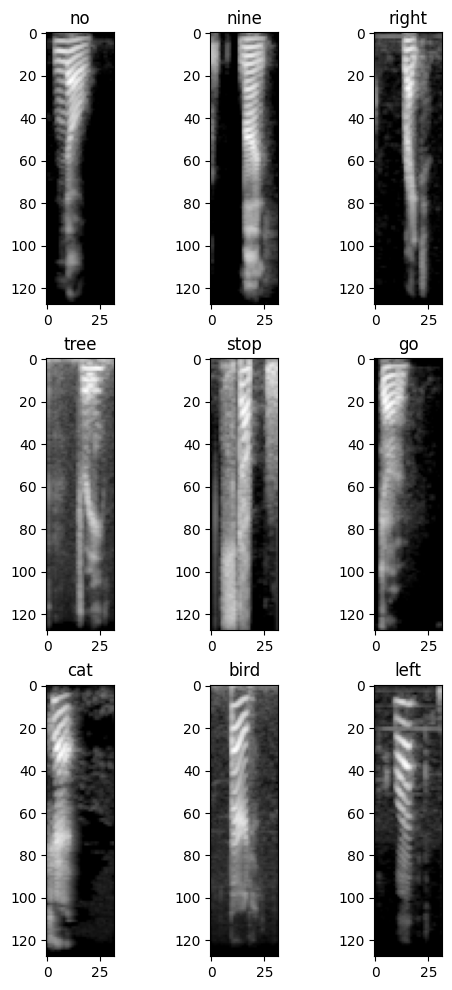

In [ ]:
import matplotlib.pyplot as plt

words = train_dataset.class_names
fig, axs = plt.subplots(3, 3, figsize=(6, 12))
for images, labels in train_dataset.take(1):
    for ax, img in zip(axs.flat, range(9)):
      ax.imshow(images[img], cmap='gray')
      ax.set_title(words[labels[img]])
    # Add space between the rows
    plt.subplots_adjust(hspace=0.2)

Instantiating a small convnet

In [ ]:
from tensorflow import keras
from keras import Input
from keras import Model
from keras import layers

words = train_dataset.class_names
print(len(words))


30


In [ ]:
# Small convnet François Chollet "Deep Learning with Python" Listing 8.1
inputs = Input(shape=(128, 32, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(len(words), activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
# prompt: Code an alternative model that includes BatchNormalization before each activation

inputs = Input(shape=(128, 32, 1))
x = layers.Conv2D(filters=32, kernel_size=3)(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(len(words), activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)


In [ ]:
# prompt: Code an alternative model that includes dropouts

inputs = Input(shape=(128, 32, 1))
x = layers.Conv2D(filters=32, kernel_size=3)(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(filters=64, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(filters=128, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(len(words), activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)


Displaying the model's summary

In [ ]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 128, 32, 1)]      0         
                                                                 
 conv2d_21 (Conv2D)          (None, 126, 30, 32)       320       
                                                                 
 batch_normalization_21 (Ba  (None, 126, 30, 32)       128       
 tchNormalization)                                               
                                                                 
 activation_21 (Activation)  (None, 126, 30, 32)       0         
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 63, 15, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 63, 15, 32)        0   

Training the convnet using the datasets

In [ ]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

Prepare callbacks

In [ ]:
# ModelCheckpoint to save best model
from keras.callbacks import ModelCheckpoint

saved_model_file = "convnet_from_scratch.keras.tf"  # Must use suffix .tf
callbacks = [
        ModelCheckpoint(
        filepath=saved_model_file,
        save_best_only=True,
        monitor="val_loss")
]

In [ ]:
# An alternative callbacks that has early stopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

# Prepare callbacks
saved_model_file = "convnet_from_scratch.keras.tf"  # Must use suffix .tf
callbacks = [
        ModelCheckpoint(
        filepath=saved_model_file,
        save_best_only=True,
        monitor="val_loss"),
        EarlyStopping(monitor='val_loss', patience=3)
]


Train model

In [ ]:
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validate_dataset,
    callbacks=callbacks)

Epoch 1/20
1597/1597 [==============================] - 22s 13ms/step - loss: 1.5985 - accuracy: 0.6223 - val_loss: 0.9768 - val_accuracy: 0.7401
Epoch 2/20
1597/1597 [==============================] - 20s 13ms/step - loss: 0.5489 - accuracy: 0.8409 - val_loss: 0.4906 - val_accuracy: 0.8595
Epoch 3/20
1597/1597 [==============================] - 21s 13ms/step - loss: 0.4100 - accuracy: 0.8827 - val_loss: 0.4766 - val_accuracy: 0.8592
Epoch 4/20
1597/1597 [==============================] - 20s 12ms/step - loss: 0.3371 - accuracy: 0.9027 - val_loss: 0.5623 - val_accuracy: 0.8511
Epoch 5/20
1597/1597 [==============================] - 19s 12ms/step - loss: 0.2940 - accuracy: 0.9144 - val_loss: 0.5548 - val_accuracy: 0.8542
Epoch 6/20
1597/1597 [==============================] - 21s 13ms/step - loss: 0.2571 - accuracy: 0.9272 - val_loss: 0.4740 - val_accuracy: 0.8637
Epoch 7/20
1597/1597 [==============================] - 21s 13ms/step - loss: 0.2320 - accuracy: 0.9327 - val_loss: 0.3876 -

Save the last model

In [ ]:
model.save('last_model.keras.tf')

Displaying curves of loss and accuracy during training

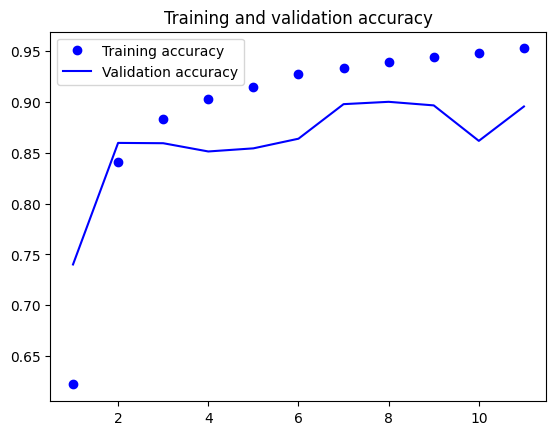

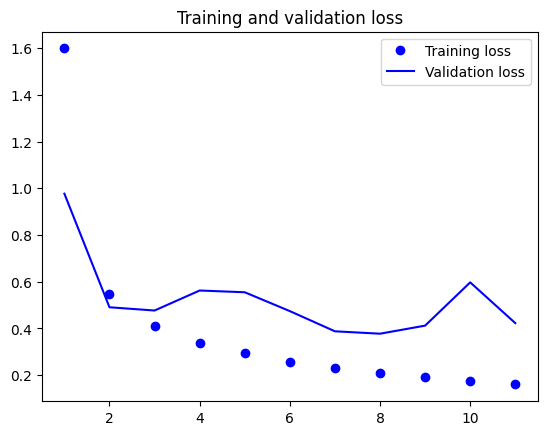

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Load the best model for testing.

In [ ]:
test_model = keras.models.load_model(saved_model_file)

Evaluating the model accuracy on the test set

In [ ]:
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

214/214 [==============================] - 2s 8ms/step - loss: 0.4068 - accuracy: 0.8960
Test accuracy: 0.896


Create lists of predictions and labels fore evaluating by various methods

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

i_true = [] # list of true labels
i_pred = [] # list of predictions

for batch in test_dataset:
    data, labels = batch
    y_pred = test_model.predict(data)
    # For each case in batch find the label with largest score
    ib_pred = np.argmax(y_pred, axis=1) # b stands for batch
    # Concatenate predictions of all batches
    i_pred.extend(ib_pred)
    # Concatenate true lables of all batches as well
    ib_true = labels.numpy().tolist()
    i_true.extend(ib_true)


1/1 [==============================] - 0s 90ms/step


Evaluating the best model using accuracy and macro-averaged F1 score on the test set

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
# Calculate accuracy
accuracy = accuracy_score(i_true, i_pred)
accuracy

0.8959765910753474

In [ ]:
# Calculate the macro-averaged F1 score
f1_macro = f1_score(i_true, i_pred, average='macro')
f1_macro

0.8975281204168984

Draw a confusion matrix

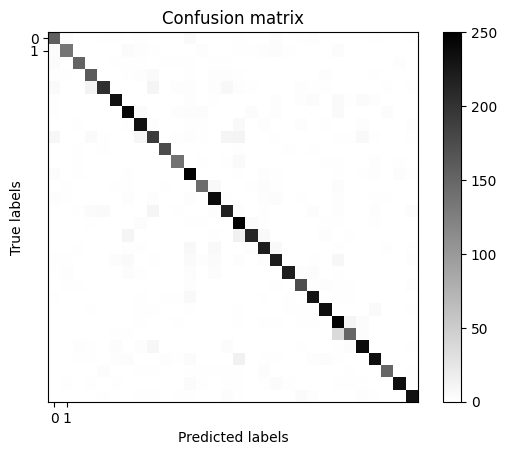

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(i_true, i_pred)

plt.imshow(cm, cmap='binary')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks([0, 1])
plt.yticks([0, 1])
plt.title('Confusion matrix')
plt.colorbar()
plt.show()

Print tuples of (true_label, predicted_label) for first 30

In [ ]:
compare = zip(i_true, i_pred)
for i,item in enumerate(compare):
    print(item)
    if i==30:
      break

(5, 5)
(13, 13)
(21, 21)
(1, 1)
(4, 4)
(16, 16)
(15, 15)
(22, 22)
(18, 18)
(21, 21)
(3, 3)
(8, 8)
(19, 21)
(21, 21)
(4, 8)
(8, 8)
(24, 24)
(4, 4)
(20, 20)
(5, 5)
(4, 4)
(6, 6)
(11, 11)
(13, 13)
(22, 22)
(18, 18)
(17, 17)
(6, 6)
(1, 0)
(11, 11)
(15, 15)


Create the dummy model using Scikit-learn function and compare performance

In [ ]:
# prompt: Generate a DummyClassifier with strategy="stratified" trained using train_dataset

from sklearn.dummy import DummyClassifier
# Extract labels from train_dataset
y_train = np.empty(0, dtype=int)
for _, labels in train_dataset:
  y_train = np.concatenate((y_train, labels.numpy()))

# Create and fit the DummyClassifier
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(None, y_train)  # No need for input features for stratified strategy

# Generate predictions for the test dataset
y_pred_dummy = dummy_clf.predict(np.zeros_like(i_true))  # Dummy input, not used

# Evaluate the dummy model
accuracy_dummy = accuracy_score(i_true, y_pred_dummy)
f1_macro_dummy = f1_score(i_true, y_pred_dummy, average='macro')

print("Dummy Classifier - Accuracy:", accuracy_dummy)
print("Dummy Classifier - Macro-averaged F1 score:", f1_macro_dummy)


Dummy Classifier - Accuracy: 0.02932551319648094
Dummy Classifier - Macro-averaged F1 score: 0.027285381214409352
